In [15]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

# Regression Analysis: Seasonal Effects with Sklearn Linear Regression
In this notebook, you will build a SKLearn linear regression model to predict qualcom ("Close") returns with *lagged* qualcom returns. 

In [16]:
# Futures contract on the qualcom price:

qualcom = pd.read_csv(
    Path("qualcom.csv"), index_col="Date",parse_dates=True
)
qualcom.tail()

Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2019-12-12  86.839996  89.230003  86.370003  89.050003  89.050003  12164600
2019-12-13  88.910004  89.699997  87.559998  87.830002  87.830002  12269100
2019-12-16  89.279999  90.459999  88.349998  88.430000  88.430000   8719100
2019-12-17  89.000000  89.040001  87.680000  88.320000  88.320000   7485900
2019-12-18  88.540001  88.650002  87.589996  87.980003  87.980003   5860600

In [17]:
# Trim the dataset to begin on December 15, 2014
qualcom = qualcom.loc["2014-12-17" :, :]
qualcom.head()

Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2014-12-18  73.279999  73.360001  72.610001  73.360001  61.294304   8864600
2014-12-19  73.290001  73.730003  73.169998  73.430000  61.352810  16332000
2014-12-22  73.580002  74.660004  73.449997  74.559998  62.296947   9074200
2014-12-23  74.610001  75.120003  74.480003  74.599998  62.330364   6405800
2014-12-24  74.690002  75.150002  74.639999  74.660004  62.380505   3791900

# Data Preparation

### Returns

In [18]:
# Create a series using "Close" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
qualcom['Return'] = qualcom.Close.pct_change() * 100
qualcom = qualcom.replace(-np.inf, np.nan).dropna()
qualcom=qualcom.replace('$', '')
qualcom.tail()

Open       High        Low      Close  Adj Close    Volume  \
Date                                                                          
2019-12-12  86.839996  89.230003  86.370003  89.050003  89.050003  12164600   
2019-12-13  88.910004  89.699997  87.559998  87.830002  87.830002  12269100   
2019-12-16  89.279999  90.459999  88.349998  88.430000  88.430000   8719100   
2019-12-17  89.000000  89.040001  87.680000  88.320000  88.320000   7485900   
2019-12-18  88.540001  88.650002  87.589996  87.980003  87.980003   5860600   

              Return  
Date                  
2019-12-12  2.368094  
2019-12-13 -1.370018  
2019-12-16  0.683136  
2019-12-17 -0.124392  
2019-12-18 -0.384960

### Lagged Returns 

In [19]:
# Create a lagged return using the shift function
qualcom['Lagged_Return'] = qualcom.Return.shift()
qualcom = qualcom.replace(-np.inf, np.nan).dropna()
qualcom.tail()

Open       High        Low      Close  Adj Close    Volume  \
Date                                                                          
2019-12-12  86.839996  89.230003  86.370003  89.050003  89.050003  12164600   
2019-12-13  88.910004  89.699997  87.559998  87.830002  87.830002  12269100   
2019-12-16  89.279999  90.459999  88.349998  88.430000  88.430000   8719100   
2019-12-17  89.000000  89.040001  87.680000  88.320000  88.320000   7485900   
2019-12-18  88.540001  88.650002  87.589996  87.980003  87.980003   5860600   

              Return  Lagged_Return  
Date                                 
2019-12-12  2.368094       3.411787  
2019-12-13 -1.370018       2.368094  
2019-12-16  0.683136      -1.370018  
2019-12-17 -0.124392       0.683136  
2019-12-18 -0.384960      -0.124392

### Train Test Split

In [20]:
# Create a train/test split for the data using 2018-2019 for testing and the rest for training
train = qualcom[:'2018']
test = qualcom['2018':]


In [21]:
# Create four dataframes:
# X_train (training set using just the independent variables), X_test (test set of of just the independent variables)
# Y_train (training set using just the "y" variable, i.e., "Futures Return"), Y_test (test set of just the "y" variable):
X_train = train["Lagged_Return"].to_frame()
X_test = test["Lagged_Return"].to_frame()
y_train = train["Return"]
y_test = test["Return"]

In [22]:
X_train.head()

Lagged_Return
Date                     
2014-12-22       0.095418
2014-12-23       1.538878
2014-12-24       0.053648
2014-12-26       0.080437
2014-12-29       1.285828

# Linear Regression Model

In [23]:
# Create a Linear Regression model and fit it to the training data
from sklearn.linear_model import LinearRegression

# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

# Make predictions using the Testing Data

Note: We want to evaluate the model using data that it has never seen before, in this case: X_test.

In [24]:
# Make a prediction of "y" values using just the test dataset
predictions = model.predict(X_test)

In [25]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = y_test.to_frame()
Results["Predicted Return"] = predictions
#Results.head()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000148C2EE8198>,
      dtype=object)

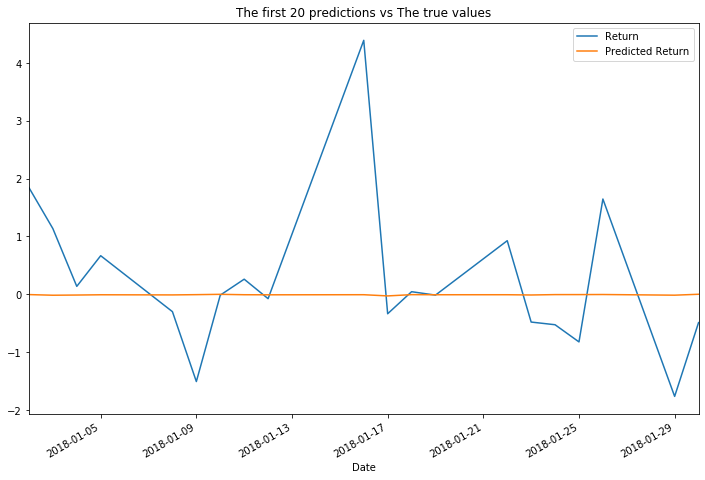

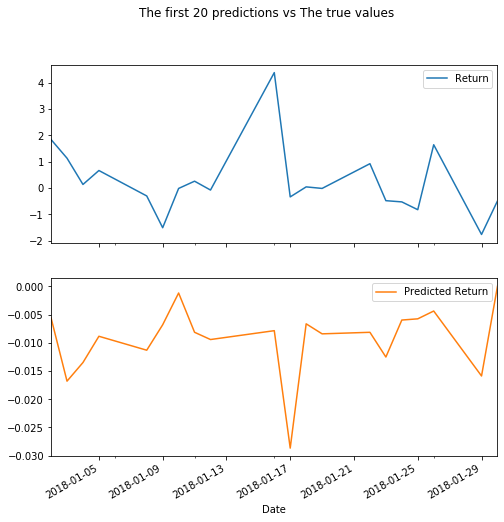

In [26]:
# Plot the first 20 predictions vs the true values
Results[:20].plot(title='The first 20 predictions vs The true values', figsize=(12, 8))
Results[:20].plot(subplots=True, figsize=(8, 8), title='The first 20 predictions vs The true values')

# Out-of-Sample Performance

Evaluate the model using "out-of-sample" data (X_test and y_test)

In [27]:
from sklearn.metrics import mean_squared_error
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
mse = mean_squared_error(
    Results["Return"],
    Results["Predicted Return"]
)

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
rmse = np.sqrt(mse)
print(f"Out-of-Sample Root Mean Squared Error (RMSE): {rmse}")

Out-of-Sample Root Mean Squared Error (RMSE): 2.2342129481780177


# In-Sample Performance

Evaluate the model using in-sample data (X_train and y_train)

In [28]:
# Construct a dataframe using just the "y" training data:
in_sample_results = y_train.to_frame()

# Add a column of "in-sample" predictions to that dataframe:  
in_sample_results["In-sample Predictions"] = model.predict(X_train)

# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
in_sample_mse = mean_squared_error(
    in_sample_results["Return"],
    in_sample_results["In-sample Predictions"]
)

# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
in_sample_rmse = np.sqrt(in_sample_mse)
print(f"In-sample Root Mean Squared Error (RMSE): {in_sample_rmse}")

In-sample Root Mean Squared Error (RMSE): 1.8294587896366694


# Conclusions

YOUR CONCLUSIONS HERE!

### lower RMSE is the the sign of fitness of our model, that is why this model perform better with in-Sample data utilization! 